- 모드가 2개인 토이 데이터 셋에서 오토 인코더를 사용해 보기

In [1]:
import torch
from torch import nn
import torch.nn.functional as F

from torch.utils.data import Dataset, DataLoader

from collections import OrderedDict

import matplotlib.pyplot as plt

In [90]:
N = 1000

def get_sample_dataset(amount=1000, random_scale=1,noise_scale=3):
    def f(x):
        return ((x + 2) * (x - 1) * (x - 2) + 5) / 5
    
    x = torch.linspace(-3, 3, amount)

    y = torch.zeros_like(x)
    y[::2] = f(x[::2]) + torch.randn(N//2) * random_scale + noise_scale
    y[1::2] = f(x[1::2]) + torch.randn(N//2) * random_scale - noise_scale

    return torch.cat([x.view(-1, 1), y.view(-1, 1)], dim=1)

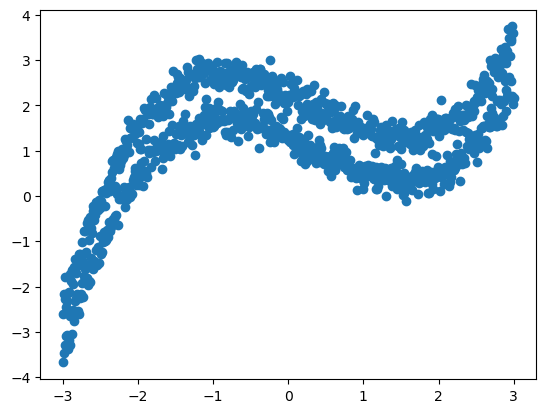

In [129]:
data = get_sample_dataset(random_scale=0.2, noise_scale=0.5)

plt.scatter(data[:, 0], data[:, 1])
plt.show()

In [149]:
encoder = nn.Sequential(
    nn.Linear(2, 32),
    nn.ReLU(),
    nn.Linear(32, 32),
    nn.ReLU(),
    nn.Linear(32, 2),
)

decoder = nn.Sequential(
    nn.Linear(1, 32),
    nn.ReLU(),
    nn.Linear(32, 32),
    nn.ReLU(),
    nn.Linear(32, 2),
)

model = nn.Sequential(
    OrderedDict(
        [
            ("encoder", encoder),
            ("decoder", decoder),
        ]
    )
)

optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

In [131]:
class TmpDataset(Dataset):
    def __init__(self, x):
        self.x = x
        self.y = x

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

dataloader = DataLoader(
    TmpDataset(data), batch_size=100, shuffle=True
)

In [14]:
def run(model, dataloader, optimizer, epochs=30):
    for _ in range(epochs):
        for x, _ in dataloader:
            h = model.get_submodule("encoder")(x)
            mu = h[:, :1]
            log_sigma = h[:, 1:2]
            sigma = log_sigma.exp()
            z = torch.rand_like(mu) * sigma + mu
            pred = model.get_submodule("decoder")(z)
            kl = 0.5 * (mu.square() + sigma.square() - log_sigma - 1).sum(dim=1).mean()
            ll = F.mse_loss(pred, x, reduction='sum') / len(x)
            loss = ll + kl

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

In [132]:
run(model, dataloader, optimizer, 1000)

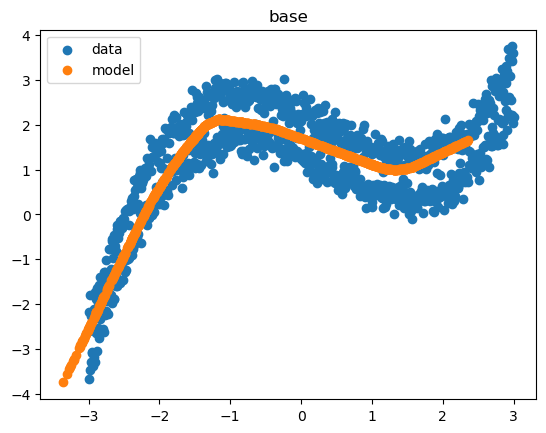

In [136]:
with torch.no_grad():
    h = model.get_submodule("encoder")(data)
    mu = h[:, :1]
    # mu = torch.randn(100, 1)
    ty = model.get_submodule("decoder")(mu)

plt.scatter(data[:, 0], data[:, 1], label='data')
plt.scatter(ty[:, 0], ty[:, 1], label='model')
plt.legend()
plt.title('base')
plt.show()

In [141]:
tmp_z = torch.randn(N//10, 1)
with torch.no_grad():
    tmp_pred = model.get_submodule("decoder")(tmp_z)

dist = (torch.transpose(tmp_pred.repeat(N, 1, 1), 0, 1) - data).square().sum(dim=2)
new_indices = dist.argmin(dim=1)

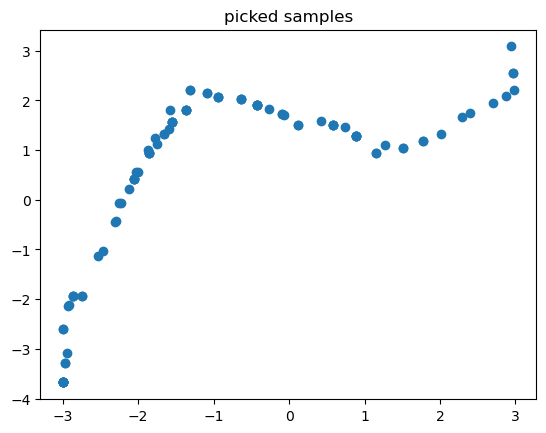

In [143]:
new_data = data[new_indices]
plt.scatter(new_data[:, 0], new_data[:, 1])
plt.title('picked samples')
plt.show()

In [174]:
new_data.shape

torch.Size([100, 2])

In [144]:
new_dataloader = DataLoader(
    TmpDataset(new_data), batch_size=20, shuffle=True
)

In [145]:
run(model, new_dataloader, optimizer, 1000)

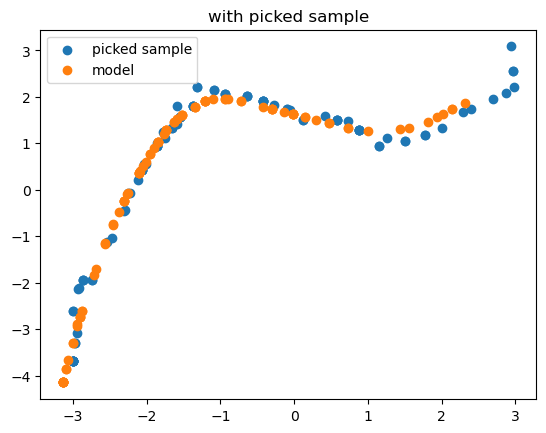

In [147]:
with torch.no_grad():
    h = model.get_submodule("encoder")(new_data)
    mu = h[:, :1]
    # mu = torch.randn(100, 1)
    ty = model.get_submodule("decoder")(mu)

plt.scatter(new_data[:, 0], new_data[:, 1], label='picked sample')
plt.scatter(ty[:, 0], ty[:, 1], label='model')
plt.legend()
plt.title('with picked sample')
plt.show()

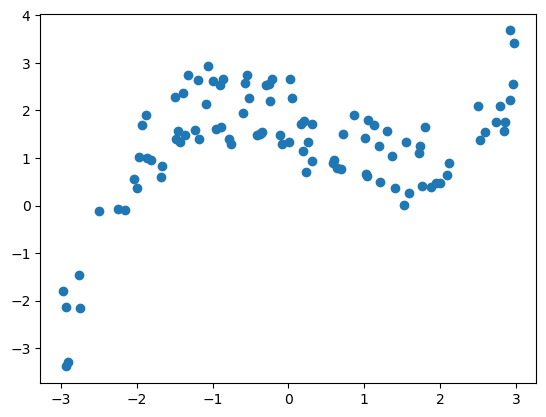

In [148]:
r_data = data[torch.randperm(len(data))[:N//10]]

plt.scatter(r_data[:, 0], r_data[:, 1])
plt.show()

In [150]:
r_dataloader = DataLoader(
    TmpDataset(r_data), batch_size=20, shuffle=True
)

In [151]:
run(model, r_dataloader, optimizer, 1000)

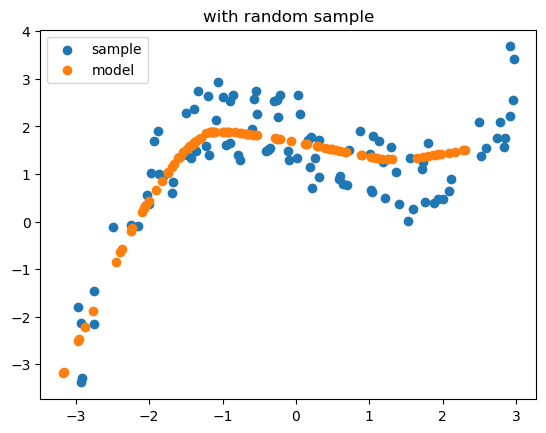

In [152]:
with torch.no_grad():
    h = model.get_submodule("encoder")(r_data)
    mu = h[:, :1]
    # mu = torch.randn(100, 1)
    ty = model.get_submodule("decoder")(mu)

plt.scatter(r_data[:, 0], r_data[:, 1], label='sample')
plt.scatter(ty[:, 0], ty[:, 1], label='model')
plt.legend()
plt.title('with random sample')
plt.show()